In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol
from pysabr import Hagan2002LognormalSABR
from pysabr import hagan_2002_lognormal_sabr as sabr
from pysabr.black import lognormal_call
import yfinance as yf
from scipy.stats import triang, norm
import pandas as pd

In [5]:
import random
import math

random.seed()  # Seed the random number generator for reproducibility

def drawTwoRandomNumbers(rho):
    '''
    Draw a pair of correlated random numbers.
    @var rho: Correlation coefficient (SABR Rho)
    '''
    rand_list = []
    z1 = random.gauss(0, 1)  # First standard normal random variable
    y1 = random.gauss(0, 1)  # Second independent standard normal variable
    
    rand_list.append(z1)
    
    # Apply the correlation formula
    term1 = z1 * rho
    term2 = y1 * math.sqrt(1.0 - rho**2)
    x2 = term1 + term2
    
    rand_list.append(x2)
    return rand_list

In [6]:
def simulateSABRMonteCarloEuler(no_of_sim, no_of_steps, expiry, F_0, alpha_0, beta, rho, nu):
    '''
    Monte Carlo SABR simulation using Euler scheme.
    
    @var no_of_sim: Number of Monte Carlo paths
    @var no_of_steps: Discretization steps for option expiry
    @var expiry: Option expiry (in years)
    @var F_0: Initial forward rate
    @var alpha_0: Initial volatility
    @var beta: SABR Beta parameter
    @var rho: Correlation between asset price and volatility
    @var nu: Volatility of volatility (SABR Nu)
    '''

    dt = expiry / no_of_steps  # Time step size
    dt_sqrt = math.sqrt(dt)  # Square root of time step (for random number scaling)
    
    simulated_forwards = []
    
    # Simulate each path
    for _ in range(no_of_sim):
        F_t = F_0
        alpha_t = alpha_0
        
        for _ in range(1, no_of_steps + 1):
            # Apply boundary conditions for F_t
            if (beta > 0 and beta < 1) and F_t <= 0:
                F_t = 0
                break
            else:
                # Generate correlated random numbers
                rand = drawTwoRandomNumbers(rho)
                
                # Simulate forward rate (Euler scheme)
                dW_F = dt_sqrt * rand[0]
                F_b = abs(F_t)**beta  # Apply beta exponent
                F_t = F_t + alpha_t * F_b * dW_F  # Update forward rate

                # Apply zero-absorbing boundary
                if F_t < 0:
                    F_t = 0
                
                # Simulate stochastic volatility (Euler scheme)
                dW_alpha = dt_sqrt * rand[1]
                alpha_t = alpha_t + nu * alpha_t * dW_alpha  # Update volatility
        
        # Store the final forward rate
        simulated_forwards.append(F_t)
    
    return simulated_forwards

In [15]:
import numpy as np

def simulateSABRMonteCarloEuler_optimized(no_of_sim, no_of_steps, expiry, F_0, alpha_0, beta, rho, nu):
    dt = expiry / no_of_steps
    dt_sqrt = np.sqrt(dt)
    
    # Initialize matrices for simulations
    F_t = np.full(no_of_sim, F_0)  # Forward prices
    alpha_t = np.full(no_of_sim, alpha_0)  # Volatility paths

    # Generate correlated random numbers all at once
    Z1 = np.random.normal(0, 1, (no_of_steps, no_of_sim))
    Y1 = np.random.normal(0, 1, (no_of_steps, no_of_sim))
    Z2 = rho * Z1 + np.sqrt(1 - rho ** 2) * Y1  # Correlated noise
    
    # Perform vectorized Monte Carlo simulation
    for i in range(no_of_steps):
        F_b = np.abs(F_t) ** beta
        dW_F = dt_sqrt * Z1[i]
        dW_alpha = dt_sqrt * Z2[i]

        # Update forward rates and volatilities
        F_t = np.where(F_t > 0, F_t + alpha_t * F_b * dW_F, 0)
        alpha_t = alpha_t + nu * alpha_t * dW_alpha

    return F_t  # Return all simulated final forward values

In [16]:
# 1. Generate SABR parameters
def generate_sabr_parameters(n_samples):
    alpha = np.random.uniform(0.1, 0.8, n_samples)
    beta = np.full(n_samples, 1.0)  # Fixed beta as per the provided document
    nu = np.random.uniform(0.05, 0.5, n_samples)
    
    # Triangle distribution for rho with lower=-1, upper=0, mode=-0.3
    c = ( -0.3 - (-1) ) / (0 - (-1))  # Mode adjustment
    rho = triang.rvs(c, loc=-1, scale=1, size=n_samples)

    return alpha, beta, rho, nu


# 2. Generate Market Data
def generate_market_data(n_samples):
    strikes = np.arange(1000, 5101, 100)  # strikes
    T = np.random.uniform(0.05, 12.5, n_samples)
    S_t = np.random.uniform(1300, 3300, n_samples)
    
    # Interest rate as a function of T
    # !!!!!!! needs to be changed!!!!
    r = np.random.uniform(0.005, 0.05, n_samples)
    
    return strikes, T, S_t, r


# 4. Generate Simulated Dataset
def generate_simulated_dataset(n_samples=10000):
    alpha, beta, rho, nu = generate_sabr_parameters(n_samples)
    strikes, T, S_t, r = generate_market_data(n_samples)

    dataset = []

    for i in range(n_samples):
        implied_vols = []
        F0 = S_t[i]*np.exp(r[i]*T[i])
        steps = 5000 # int(T[i]*252)
        S = simulateSABRMonteCarloEuler_optimized(no_of_sim=15000, no_of_steps=steps, expiry=T[i], F_0=F0, alpha_0=alpha[i], beta=beta[i], rho=rho[i], nu=nu[i])
        #puts = np.array([np.exp(-r*T)*np.mean(np.maximum(k-S,0)) for k in strikes])
        calls = np.array([np.exp(-r[i]*T[i])*np.mean(np.maximum(S-k,0)) for k in strikes])
        #put_ivs = implied_vol(puts, S0, K, T, r, flag='p', q=0, return_as='numpy', on_error='ignore')
        call_ivs = implied_vol(calls, S_t[i], strikes, T[i], r[i], flag='c', q=0, return_as='numpy', on_error='ignore')
        call_ivs = call_ivs * 100
        
        # Concatenate parameters and implied volatilities
        data_point = [alpha[i], beta[i], rho[i], nu[i], T[i], F0] + call_ivs.tolist()
        dataset.append(data_point)

    columns = ['alpha', 'beta', 'rho', 'nu', 'T', 'F0'] + [f'IV_{k}' for k in strikes]
    df = pd.DataFrame(dataset, columns=columns)
    return df

In [20]:
df = generate_simulated_dataset(1000)
df

,alpha,beta,rho,nu,T,F0,IV_1000,IV_1100,IV_1200,IV_1300,...,IV_4200,IV_4300,IV_4400,IV_4500,IV_4600,IV_4700,IV_4800,IV_4900,IV_5000,IV_5100
0,0.672107,1.0,-0.309243,0.363602,7.584898,2977.050879,63.534859,62.767966,62.089414,61.480861,...,54.971797,54.898942,54.830292,54.765472,54.705544,54.650915,54.599742,54.551926,54.506249,54.461000
1,0.641428,1.0,-0.616095,0.479021,8.888744,3776.347002,65.179780,63.410407,61.865295,60.500185,...,44.777612,44.534460,44.300206,44.074110,43.858344,43.651263,43.451055,43.256465,43.067962,42.887002
2,0.171748,1.0,-0.096449,0.219086,3.142236,1540.093367,18.411470,18.166646,17.933139,17.742724,...,19.814723,19.890673,19.958826,20.033247,20.048374,20.029919,19.974594,19.803845,19.602697,19.388255
3,0.247441,1.0,-0.424665,0.315980,9.701002,2059.088838,28.971336,28.094825,27.321799,26.633674,...,22.110490,22.160270,22.215002,22.271095,22.328727,22.390041,22.449473,22.505787,22.562398,22.620036
4,0.516982,1.0,-0.442561,0.331136,8.591609,4215.235652,52.531270,51.902894,51.324159,50.784083,...,43.288540,43.158669,43.032491,42.909789,42.788759,42.672649,42.560498,42.452725,42.347335,42.246570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.200246,1.0,-0.789728,0.140409,8.864181,3231.814902,0.000000,0.000000,17.446025,18.760193,...,17.364290,17.259126,17.158936,17.061584,16.965768,16.868913,16.768388,16.666819,16.565959,16.468241
996,0.637116,1.0,-0.141781,0.122635,11.129930,1729.066673,49.479096,50.004649,50.432415,50.783171,...,53.673571,53.704786,53.735540,53.763984,53.790237,53.814956,53.838984,53.860951,53.880585,53.899115
997,0.213150,1.0,-0.082466,0.166610,5.304660,2388.012419,19.255258,20.294555,20.747686,20.958258,...,21.342579,21.374076,21.406393,21.433820,21.457308,21.486818,21.523629,21.562169,21.600855,21.641792
998,0.603494,1.0,-0.366003,0.423125,1.503235,2497.401522,58.743969,59.058244,59.111523,58.974486,...,53.557126,53.497452,53.437093,53.384713,53.335842,53.289772,53.237278,53.194295,53.162631,53.136331


In [21]:
from pysabr import Hagan2002LognormalSABR
from pysabr import hagan_2002_lognormal_sabr as sabr
from pysabr.black import lognormal_call

strikes = np.arange(1000, 5101, 100)  
f = df['F0'].values[0]
t = df['T'].values[0]
alpha = df['alpha'].values[0]
beta = df['beta'].values[0]
rho = df['rho'].values[0]
volvol = df['nu'].values[0]

calibrated_vols = [
    sabr.lognormal_vol(strike, f, t, alpha, beta, rho, volvol) * 100
    for strike in strikes
]

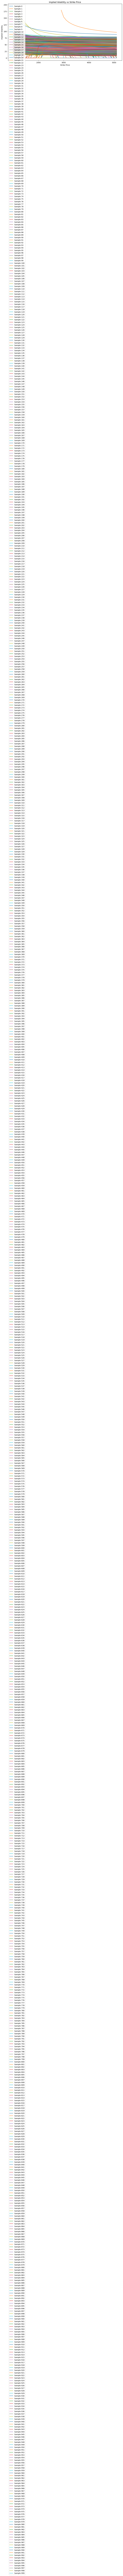

In [22]:
def plot_iv_vs_strike(df):
    '''
    Plot the implied volatilities against strike prices.
    @param df: DataFrame containing the simulated data
    '''
    strikes = np.arange(1000, 5101, 100)
    iv_columns = [f'IV_{k}' for k in strikes]
    
    plt.figure(figsize=(12, 6))
    for i, row in df.iterrows():
        plt.plot(strikes, row[iv_columns], label=f'Sample {i}')
    plt.plot(strikes, calibrated_vols)
    plt.xlabel('Strike Price')
    plt.ylabel('Implied Volatility')
    plt.title('Implied Volatility vs Strike Price')
    plt.legend()
    plt.show()

# Generate a small dataset for plotting
plot_iv_vs_strike(df)

In [23]:
df.to_csv("saved_dataframe.csv", index=False)
